In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

# Environment & Data Configuration

In [11]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
n_obs = 9
trajectory_length = 20  # numer of node visits in a trajectory
num_desired_trajectories= 30

# choose env from "random", "small world" or "dead ends"
# TODO devouple batch_size from trajectory length for GraphEnv
# env = GraphEnv(n_nodes=n_nodes, n_items=n_obs, env='regular', action_type = "regular", batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 5, "cols": 5}
            )
# env = GraphEnv( n_items=n_nodes,                     # number of possible observations
#                 env='two tunnel', 
#                 batch_size=trajectory_length, 
#                 num_desired_trajectories=num_desired_trajectories, 
#                 device=None, 
#                 unique=True,                         # each state is assigned a unique observation if true
#                 args = {"tunnel_length": 1, "middle_tunnel_length": 1}
#             )

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
train_dataset = env.gen_dataset(fixed_start=False)
test_dataset = env.gen_dataset(fixed_start=False)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

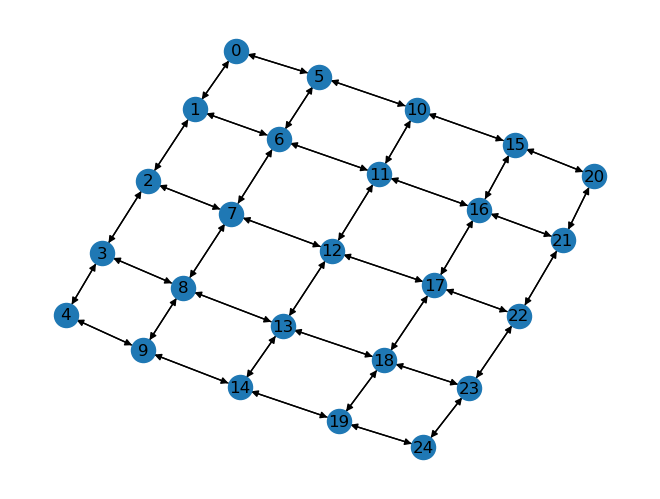

number of actions: 4
Sample trajectory:
tensor([[[24,  2, 23],
         [23,  2, 22],
         [22,  3, 23],
         [23,  3, 24],
         [24,  2, 23],
         [23,  2, 22],
         [22,  2, 21],
         [21,  2, 20],
         [20,  3, 21],
         [21,  2, 20],
         [20,  3, 21],
         [21,  3, 22],
         [22,  0, 17],
         [17,  0, 12],
         [12,  3, 13],
         [13,  0,  8],
         [ 8,  3,  9],
         [ 9,  0,  4],
         [ 4,  1,  9]]])
S-O mapping:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24])
action-to-node:
{1: tensor([19, 24]), 3: tensor([23, 24]), 2: tensor([24, 23]), 0: tensor([24, 19])}
node-to-action-matrix:
tensor([[-1,  3, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 2, -1,  3, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [-1,  2, -1,  3, -1, 

In [12]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float), create_using = nx.DiGraph)

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("Sample trajectory:")
for trajectory in train_dataloader:
    print(trajectory)
    break

print("S-O mapping:")
print(env.items)
print("action-to-node:")
print(env.action_to_node)
print("node-to-action-matrix:")
print(env.node_to_action_matrix)
print("affordance / node - to action:")
print(env.affordance)

# Model & Trainer Config 

In [13]:
# Our code
from trainer import POCMLTrainer
from model import POCML, sim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = 20
random_feature_dim = 5000
epochs = 200

model = POCML(
    n_obs = env.n_items,
    n_states = env.size,
    n_actions = env.n_actions,
    state_dim = state_dim,
    random_feature_dim = random_feature_dim,
    alpha = 1,
    memory_bypass=True,
)
    
trainer = POCMLTrainer(
    model=model, 
    train_loader = train_dataloader,
    lr_Q = 0.1, 
    lr_V = 0.01, 
    lr_all = 0.05,
    normalize = True,
    reset_every=5, # never reset,
    update_state_given_obs=True,
    debug=False
)

loss_record, best_model = trainer.train(epochs)
model = best_model

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
print("State similarities:\n", model.get_state_similarities())
print("Action similarities:\n", model.get_action_similarities())

State similarities:
 tensor([[ 28.4047,  19.0427,  12.7174,   9.6605,   4.4050,  20.9629,  11.9286,
           8.2003,   4.4461,  -2.4326,  13.7799,   6.1365,   0.5766,  -3.2370,
          -9.5880,   6.6230,  -0.6593,  -7.1087, -11.6674, -17.4189,  -2.7196,
          -9.0011, -14.8647, -19.9377, -26.0140],
        [ 19.0427,  14.8239,  12.1871,  10.3617,   7.6595,  12.4424,   8.6699,
           7.2623,   5.6061,   2.0376,   6.2669,   3.2634,   1.0861,  -0.2698,
          -2.9270,  -0.2487,  -2.8058,  -5.1711,  -6.6450,  -8.5157,  -7.9384,
          -9.9551, -11.8707, -13.4891, -15.5278],
        [ 12.7174,  12.1871,  12.9078,  12.4218,  11.2979,   6.1246,   5.9453,
           6.9707,   7.3120,   5.9246,   0.5851,   0.8069,   1.3169,   1.9597,
           1.6329,  -5.3202,  -4.4486,  -3.9601,  -3.3934,  -2.8868, -11.8179,
         -10.7970,  -9.8951,  -9.3779,  -8.8059],
        [  9.6605,  10.3617,  12.4218,  14.6539,  15.9175,   3.3415,   4.3489,
           7.6998,   9.6809,  10.3646, 

In [6]:
phi_Q = model.get_state_kernel()
phi_V = model.get_action_kernel()
print("State kernel similarities:\n", sim(phi_Q, phi_Q))
print("Action kernel similarities:\n", sim(phi_V, phi_V))

State kernel similarities:
 tensor([[1.0000e+00, 4.3995e-02, 9.0464e-03, 9.0477e-03, 4.5457e-03, 1.9392e-01,
         3.1382e-02, 6.9538e-03, 2.5877e-03, 0.0000e+00, 0.0000e+00, 5.3399e-03,
         1.2289e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5363e-04, 0.0000e+00,
         0.0000e+00, 1.4612e-03, 0.0000e+00, 2.7659e-03, 1.3444e-02, 0.0000e+00,
         3.0863e-03],
        [4.3995e-02, 1.0000e+00, 1.6518e-01, 5.4775e-03, 0.0000e+00, 1.2634e-02,
         1.4143e-01, 3.5002e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.3302e-03, 2.1377e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.3163e-04,
         5.0148e-03, 6.1045e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0743e-03,
         0.0000e+00],
        [9.0464e-03, 1.6518e-01, 1.0000e+00, 5.2439e-02, 0.0000e+00, 0.0000e+00,
         2.1642e-02, 2.2239e-01, 1.3743e-01, 2.8519e-02, 8.6791e-03, 0.0000e+00,
         5.4985e-03, 1.0370e-02, 1.7230e-02, 0.0000e+00, 0.0000e+00, 5.8208e-04,
         0.0000e+00, 9.5815e-03, 3.83

In [24]:
# beta_obs, beta_state, clean up rate
torch.save(model.state_dict(), "model/model.ckpt")

In [15]:
import evaluate

train_acc, train_confidences = evaluate.accuracy(model, train_dataloader)
print("Train obs accuracy/confidence:", train_acc, np.mean(train_confidences))

test_acc, test_confidences = evaluate.accuracy(model, test_dataloader)
print("Test obs accuracy/confidence:", test_acc, np.mean(test_confidences))

sa_acc, sa_confidences, sa_distance_ratios = evaluate.state_transition_consistency(model, env)
print("State-action accuracy/confidence/distance ratio:", sa_acc, np.mean(sa_confidences), np.mean(sa_distance_ratios))

Train obs accuracy/confidence: 0.10350877192982456 0.33839670027230395
Test obs accuracy/confidence: 0.056140350877192984 0.31398986637788384
State-action accuracy/confidence/distance ratio: 0.075 0.3107157923979685 0.6417003441372733


In [ ]:
env.start_state_idx

In [ ]:
sa_distance_ratios

In [16]:
from sklearn.manifold import MDS

def visualize(distances, legend:str ="Node"):
    mds = MDS(n_components =2)
    positions = mds.fit_transform(distances)

    plt.figure(figsize=(8, 6))
    plt.scatter(positions[:, 0], positions[:, 1])

    # Optional: Annotate the points
    for i, (x, y) in enumerate(positions):
        plt.text(x, y, f'{legend} {i}', fontsize=12)

    plt.title('Graph Visualization using MDS')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


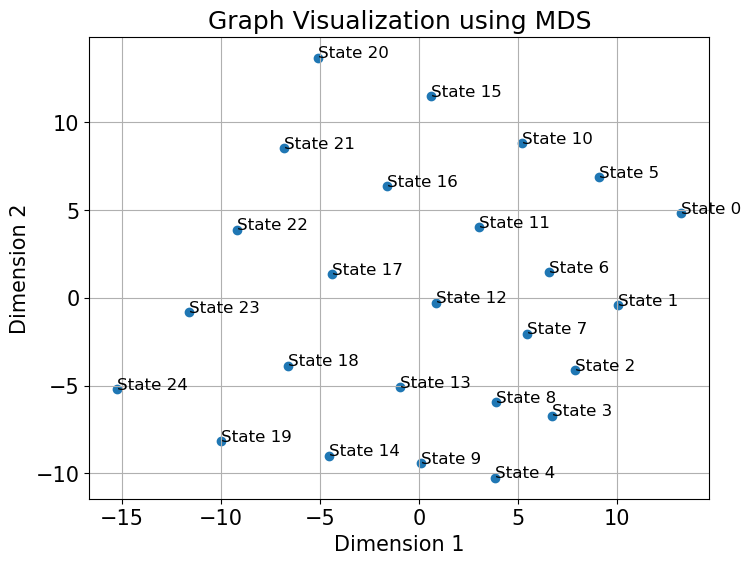

In [17]:
visualize(model.get_state_differences().numpy(), legend = "State")

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


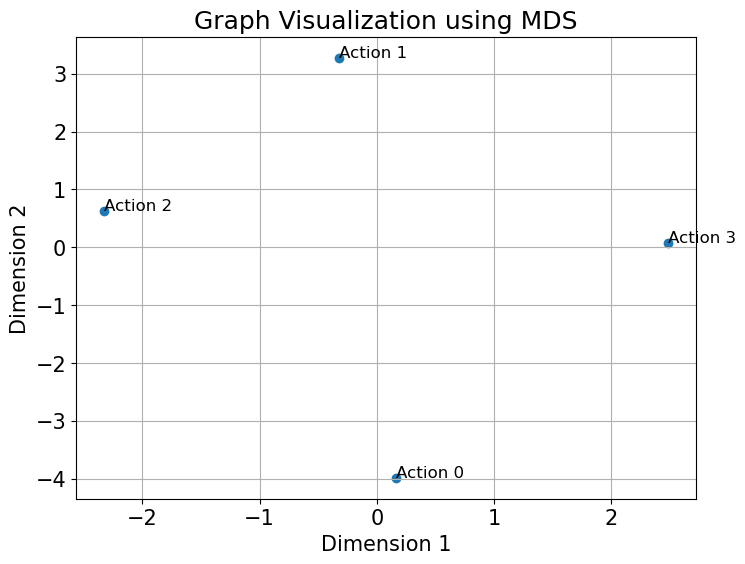

In [18]:
visualize(model.get_action_differences().numpy(), "Action")

Text(0.5, 0, 'Epochs')

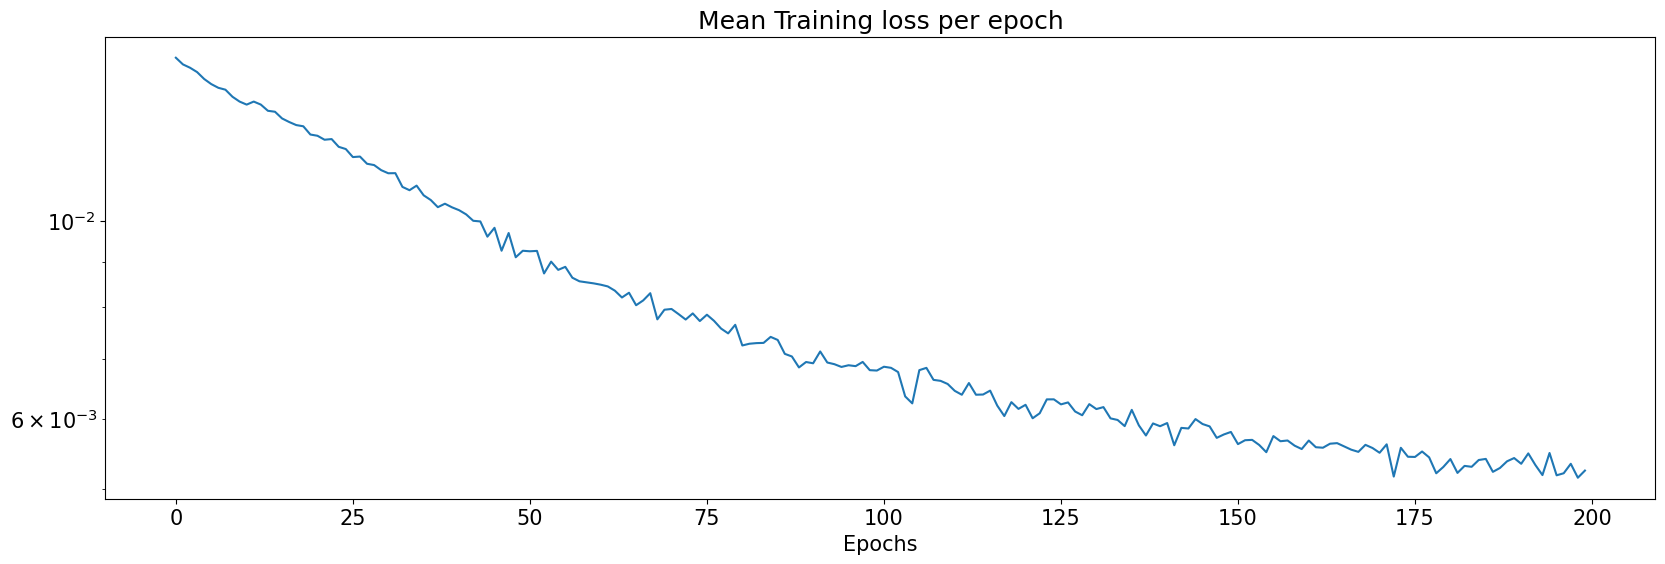

In [10]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1)/(env.num_desired_trajectories * (env.batch_size-1) ))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


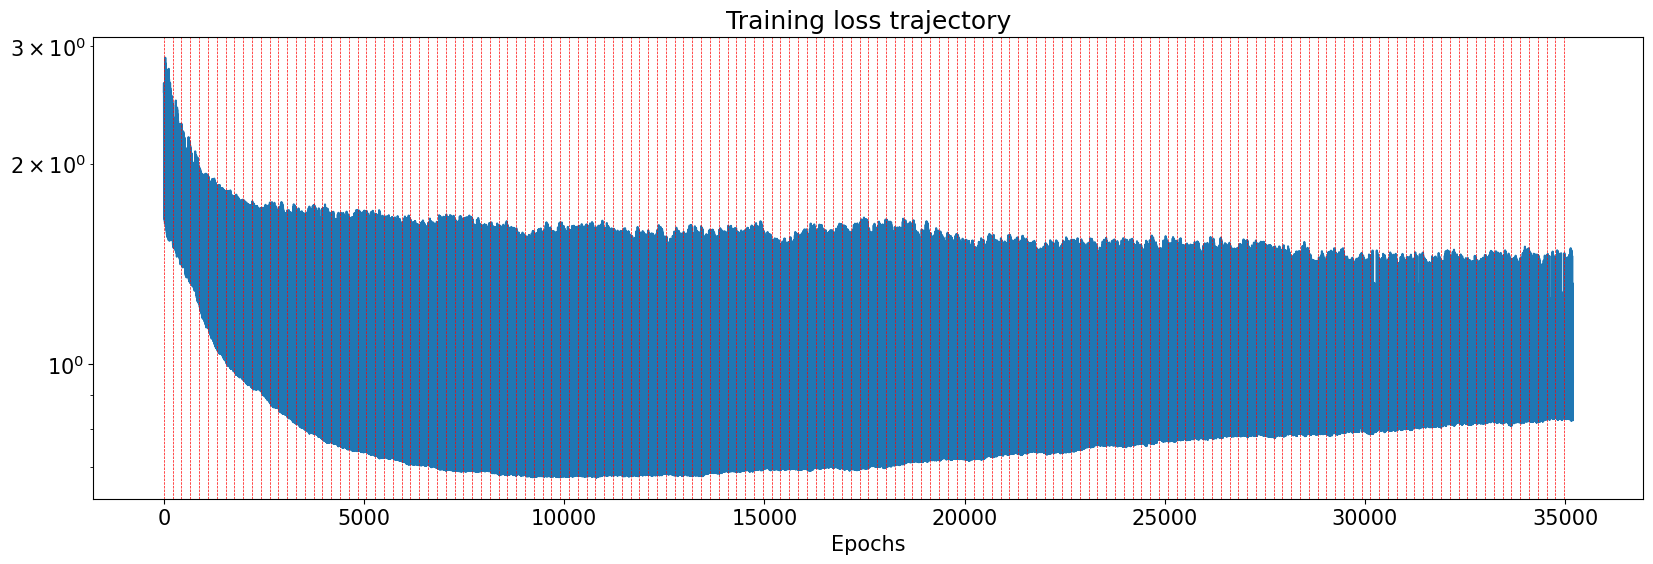

In [36]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record.reshape(-1))
plt.yscale('log')
plt.title('Training loss trajectory') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

# Get the current y-ticks
yticks = plt.yticks()[0]

print(yticks)

# Add vertical lines at each multiple of 5

for i in range(0, len(loss_record.reshape(-1)), num_desired_trajectories * (trajectory_length-1)):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.5)



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 